In [63]:
import numpy as np
import pandas as pd
import statsmodels.api as sm 
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# importing data set
df = pd.read_csv('Bitcoin Historical Data.csv')

# fixing dataset so that it can be interpreted by the model
df['Price'] = df['Price'].str.replace(',','')
df['Open'] = df['Open'].str.replace(',','')
df['High'] = df['High'].str.replace(',','')
df['Low'] = df['Low'].str.replace(',','')

df['Price'] = df['Price'].astype(float)
df['Open'] = df['Open'].astype(float)
df['High'] = df['High'].astype(float)
df['Low'] = df['Low'].astype(float)

df['Vol.'] = df['Vol.'].str.replace(',','')
df['Vol.'] = df['Vol.'].str.replace('K','')
df['Vol.'] = df['Vol.'].str.replace('M','')
df['Vol.'] = df['Vol.'].str.replace('B','')
df['Vol.'] = df['Vol.'].astype(float)
df['Vol.'] = df['Vol.'] * 1000

df['Fake_Index'] = np.array([i for i in range(0,len(df))])


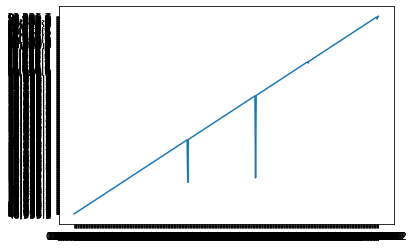

In [ ]:
plt.plot(df['Date'].iloc[1:500], df['Open'].iloc[1:500]) ## shows a seemingly linear growth over time

### **modeling with only two variables**

In [112]:
X = df[['Fake_Index', 'Open', 'Vol.']] # features (for now)
y = df['Price'] # target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.30)

model = LinearRegression() # linearity of dataset made it pretty easy to use a linear model to predict the prices just based on the opening and volume that day
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(r2_score(y_test, y_pred))

0.9978615425277159


In [113]:
y_pred = pd.Series(y_pred)
y_test = pd.Series(y_test)

train_data = pd.concat([X_train,y_train], axis=1)

orig_index = y_test.index.to_list()
y_test.reset_index(drop=True, inplace=True)

results = pd.concat([y_pred,y_test], axis=1, ignore_index=True)
results['Index'] = orig_index
results.set_index('Index', inplace=True)

results_new = pd.concat([results,X_test], axis=1)

final = pd.merge(results_new, df['Date'], left_index=True, right_index=True, how='inner')